<a href="https://colab.research.google.com/github/kollaikal/devtraining-needit-sandiego/blob/main/Stock_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import nltk
import re
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost
import lightgbm

In [2]:
# For reading stock data from yahoo
from pandas_datareader.data import DataReader
# For time stamps
from datetime import datetime

In [3]:
columns=['Date','Category','News']
news_data = pd.read_csv("/content/india-news-headlines.csv",names=columns)

In [4]:
print('Showing part of the whole dataset:')
news_data.head(5)
news_data = news_data.dropna()
news_data

Showing part of the whole dataset:


,Date,Category,News
0,publish_date,headline_category,headline_text
1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
2,20010102,unknown,Fissures in Hurriyat over Pak visit
3,20010102,unknown,America's unwanted heading for India?
4,20010102,unknown,For bigwigs; it is destination Goa
...,...,...,...
3684914,20220331,city.srinagar,J&K sacks 2 cops; 3 other employees over terro...
3684915,20220331,entertainment.hindi.bollywood,Ranbir Kapoor says 'Rishi Kapoor enjoyed his a...
3684916,20220331,city.trichy,As Covid-19 cases drop to nil in southern dist...
3684917,20220331,city.erode,Tamil Nadu sees marginal rise of Covid cases w...


In [5]:
news_data.drop(0, inplace=True)
news_data.drop('Category', axis = 1, inplace=True)
print('Showing part of the whole dataset:')
news_data.head(-5)

Showing part of the whole dataset:


,Date,News
1,20010102,Status quo will not be disturbed at Ayodhya; s...
2,20010102,Fissures in Hurriyat over Pak visit
3,20010102,America's unwanted heading for India?
4,20010102,For bigwigs; it is destination Goa
5,20010102,Extra buses to clear tourist traffic
...,...,...
3684909,20220331,Garment industry jittery over'GST hike'
3684910,20220331,AAP MLAs interfering in work: Councillors
3684911,20220331,Schools organise vax camps for kids
3684912,20220331,Madhya Pradesh CM Shivraj Singh Chouhan promis...


In [6]:
hisdf = pd.read_csv("^BSESN.csv")
hisdf.head(-5)
hisdf = hisdf.dropna()
hisdf

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-12-17,41052.359375,41401.648438,41005.179688,41352.171875,41352.171875,19000.0
1,2019-12-18,41442.750000,41614.769531,41358.468750,41558.570313,41558.570313,24300.0
2,2019-12-19,41571.820313,41719.289063,41456.398438,41673.921875,41673.921875,33300.0
3,2019-12-20,41746.199219,41809.960938,41636.109375,41681.539063,41681.539063,33600.0
4,2019-12-23,41548.261719,41701.621094,41474.609375,41642.660156,41642.660156,6200.0
...,...,...,...,...,...,...,...
247,2020-12-11,46060.320313,46309.628906,45706.218750,46099.011719,46099.011719,26300.0
248,2020-12-14,46284.699219,46373.339844,45951.531250,46253.460938,46253.460938,18400.0
249,2020-12-15,46287.390625,46350.300781,45841.671875,46263.171875,46263.171875,16400.0
250,2020-12-16,46573.308594,46704.968750,46402.199219,46666.460938,46666.460938,13100.0


In [7]:
# Check for common information of the first datast
news_data["Date"] = pd.to_datetime(news_data["Date"],format='%Y%m%d', errors='coerce')
news_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3684916 entries, 1 to 3684918
Data columns (total 2 columns):
 #   Column  Dtype         
---  ------  -----         
 0   Date    datetime64[ns]
 1   News    object        
dtypes: datetime64[ns](1), object(1)
memory usage: 84.3+ MB


In [8]:
# Ensure the 'News' column contains only strings
news_data['News'] = news_data['News'].astype(str)

# Group the headlines for each day
news_data['News'] = news_data.groupby(['Date'])['News'].transform(lambda x: ' '.join(x))
news_data = news_data.drop_duplicates()
news_data.reset_index(inplace=True,drop=True)
news_data

,Date,News
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-03,Powerless north India gropes in the dark Think...
2,2001-01-04,The string that pulled Stephen Hawking to Indi...
3,2001-01-05,Light combat craft takes India into club class...
4,2001-01-06,Light combat craft takes India into club class...
...,...,...
7712,2022-03-27,Playing a dead man in Body God meant sitting i...
7713,2022-03-28,As fashion becomes democratic; demand for styl...
7714,2022-03-29,Bobby Deol: Like my dad; I hope to be working ...
7715,2022-03-30,I will not give in to trends: Dossmode The tim...


In [9]:
news_data.isnull().sum()

Date    0
News    0
dtype: int64

In [10]:
len(news_data)

7717

In [11]:
hisdf=hisdf[["Date","Open","High","Low","Close","Volume"]]
hisdf.head(-5)

,Date,Open,High,Low,Close,Volume
0,2019-12-17,41052.359375,41401.648438,41005.179688,41352.171875,19000.0
1,2019-12-18,41442.750000,41614.769531,41358.468750,41558.570313,24300.0
2,2019-12-19,41571.820313,41719.289063,41456.398438,41673.921875,33300.0
3,2019-12-20,41746.199219,41809.960938,41636.109375,41681.539063,33600.0
4,2019-12-23,41548.261719,41701.621094,41474.609375,41642.660156,6200.0
...,...,...,...,...,...,...
242,2020-12-04,44665.910156,45148.281250,44665.910156,45079.550781,27600.0
243,2020-12-07,45099.921875,45458.921875,45024.468750,45426.968750,18700.0
244,2020-12-08,45568.800781,45742.230469,45335.171875,45608.511719,18200.0
245,2020-12-09,45891.039063,46164.101563,45792.011719,46103.500000,20700.0


In [12]:
# Check for common information of the second dataset
hisdf["Date"]= pd.to_datetime(hisdf["Date"])
hisdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250 entries, 0 to 251
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    250 non-null    datetime64[ns]
 1   Open    250 non-null    float64       
 2   High    250 non-null    float64       
 3   Low     250 non-null    float64       
 4   Close   250 non-null    float64       
 5   Volume  250 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 13.7 KB


In [13]:
hisdf.describe()

,Open,High,Low,Close,Volume
count,250.000000,250.000000,250.000000,250.000000,250.000000
mean,37804.237375,38071.182859,37422.826992,37745.454117,19134.000000
std,4507.985769,4380.974060,4647.212947,4535.304336,16540.261333
min,26499.810547,27462.869141,25638.900391,25981.240234,0.000000
25%,34369.659179,34779.932618,33975.389648,34257.097656,13125.000000
50%,38489.480469,38750.359375,38234.869140,38425.974610,17000.000000
75%,41179.222656,41376.482422,41023.923828,41135.233399,21075.000000
max,46774.320313,46992.570313,46627.601563,46890.339844,188300.000000


In [14]:
# Check for duplicated values
hisdf.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [15]:
len(hisdf)

250

Text(0, 0.5, 'BSESN')

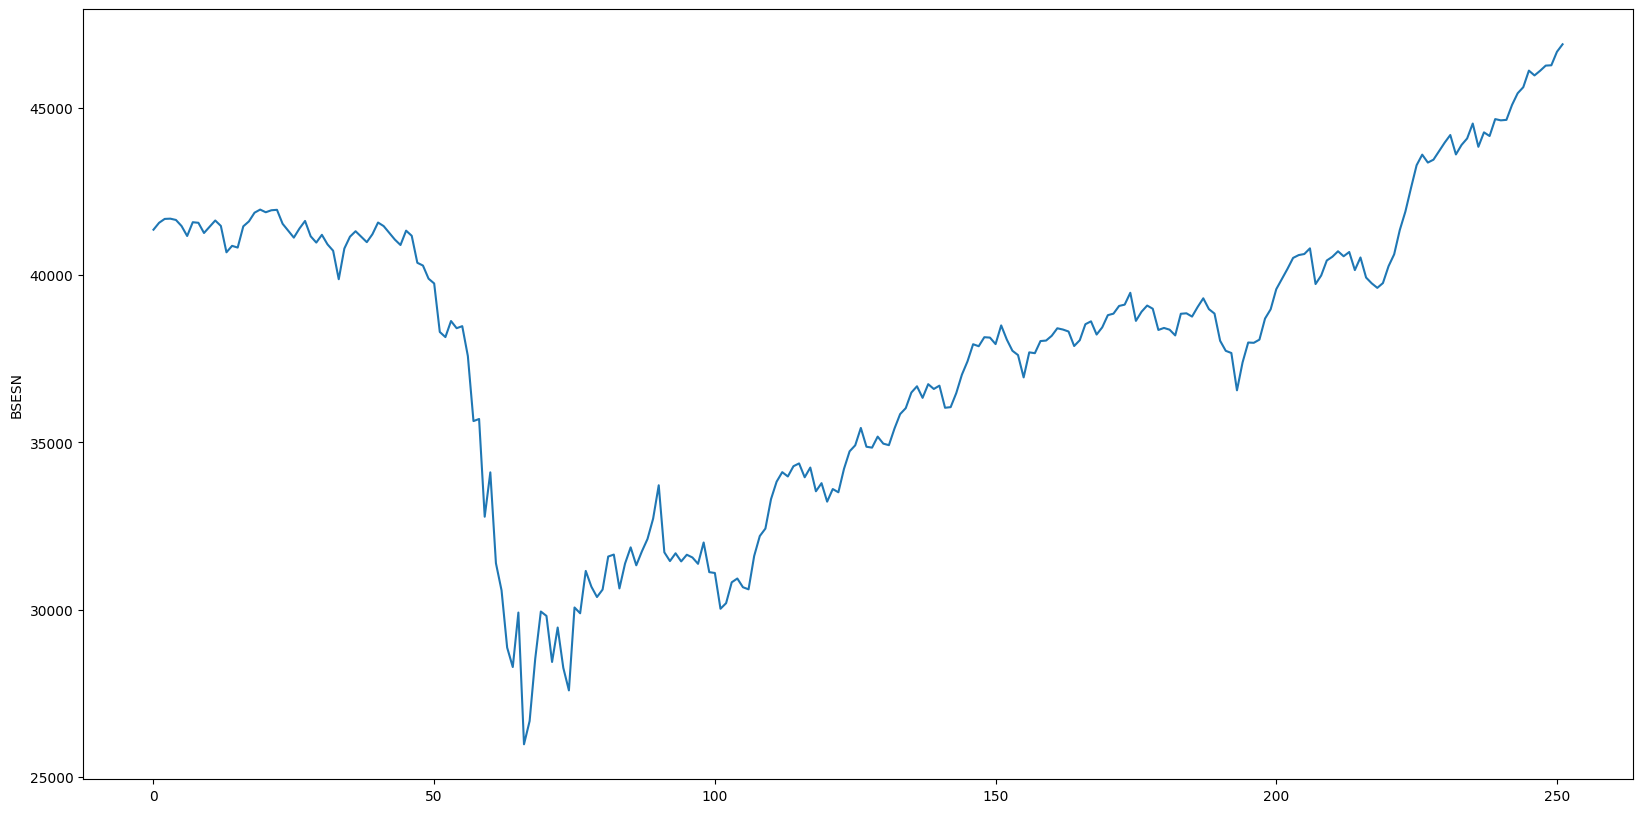

In [16]:
# Figure plot
plt.figure(figsize=(20,10))
hisdf['Close'].plot()
plt.ylabel('BSESN')

Removing unwanted characters from the news

In [17]:
#removing unwanted characters from the News
news_data.replace("[^a-zA-Z']"," ",regex=True,inplace=True)
news_data["News"].head(5)

0    Status quo will not be disturbed at Ayodhya  s...
1    Powerless north India gropes in the dark Think...
2    The string that pulled Stephen Hawking to Indi...
3    Light combat craft takes India into club class...
4    Light combat craft takes India into club class...
Name: News, dtype: object

# Historical analysis

# Plot the Moving Average

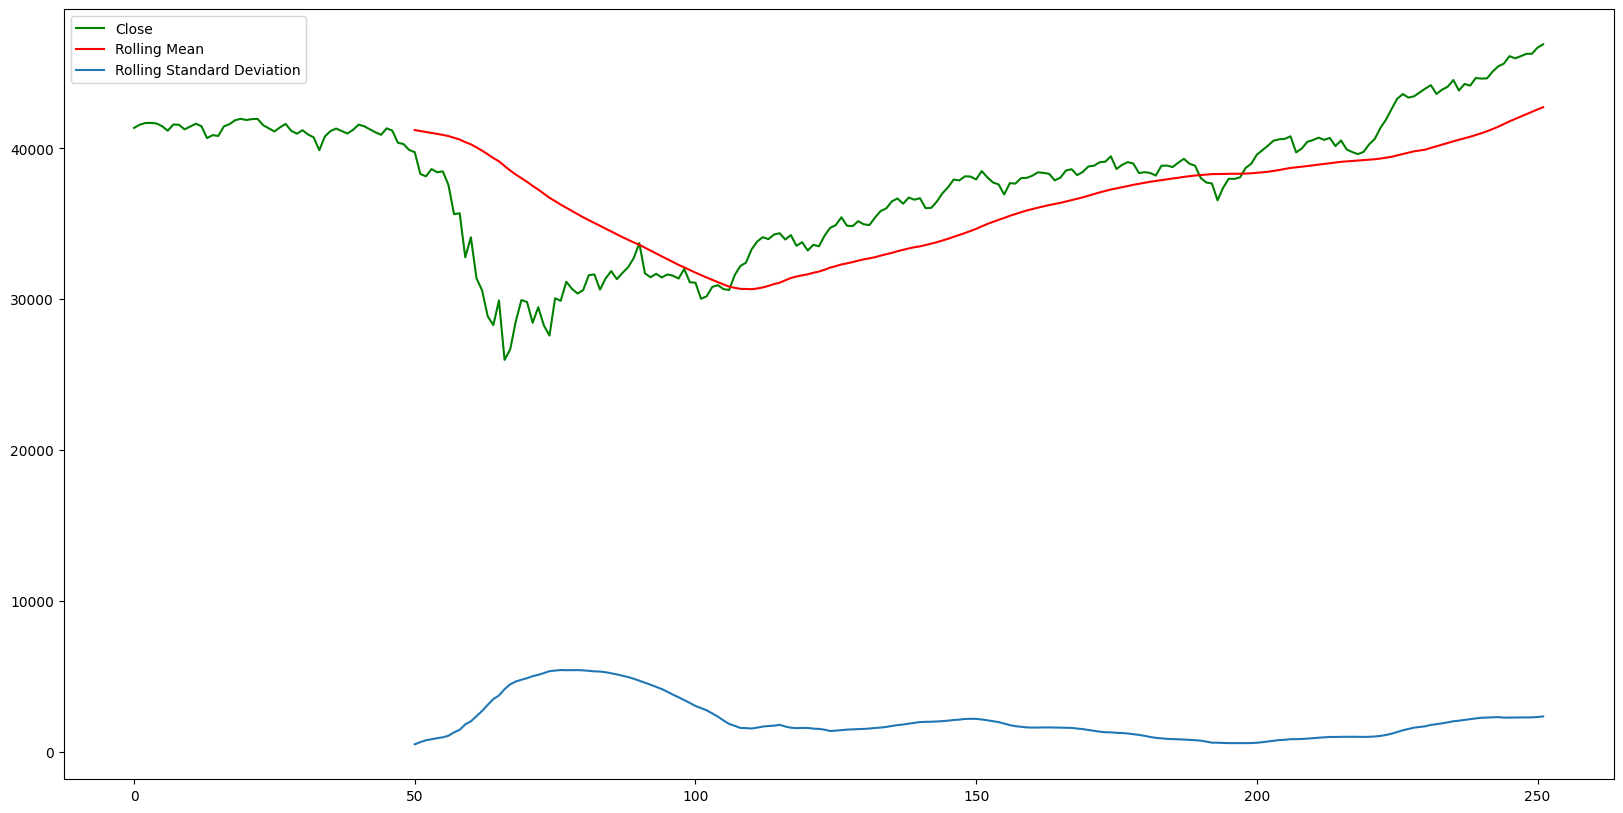

In [18]:
#Plotting moving average
close = hisdf['Close']

ma = close.rolling(window = 50).mean()
std = close.rolling(window = 50).std()

plt.figure(figsize=(20,10))
hisdf['Close'].plot(color='g',label='Close')
ma.plot(color = 'r',label='Rolling Mean')
std.plot(label = 'Rolling Standard Deviation')

plt.legend()

Text(0.5, 1.0, 'Returns')

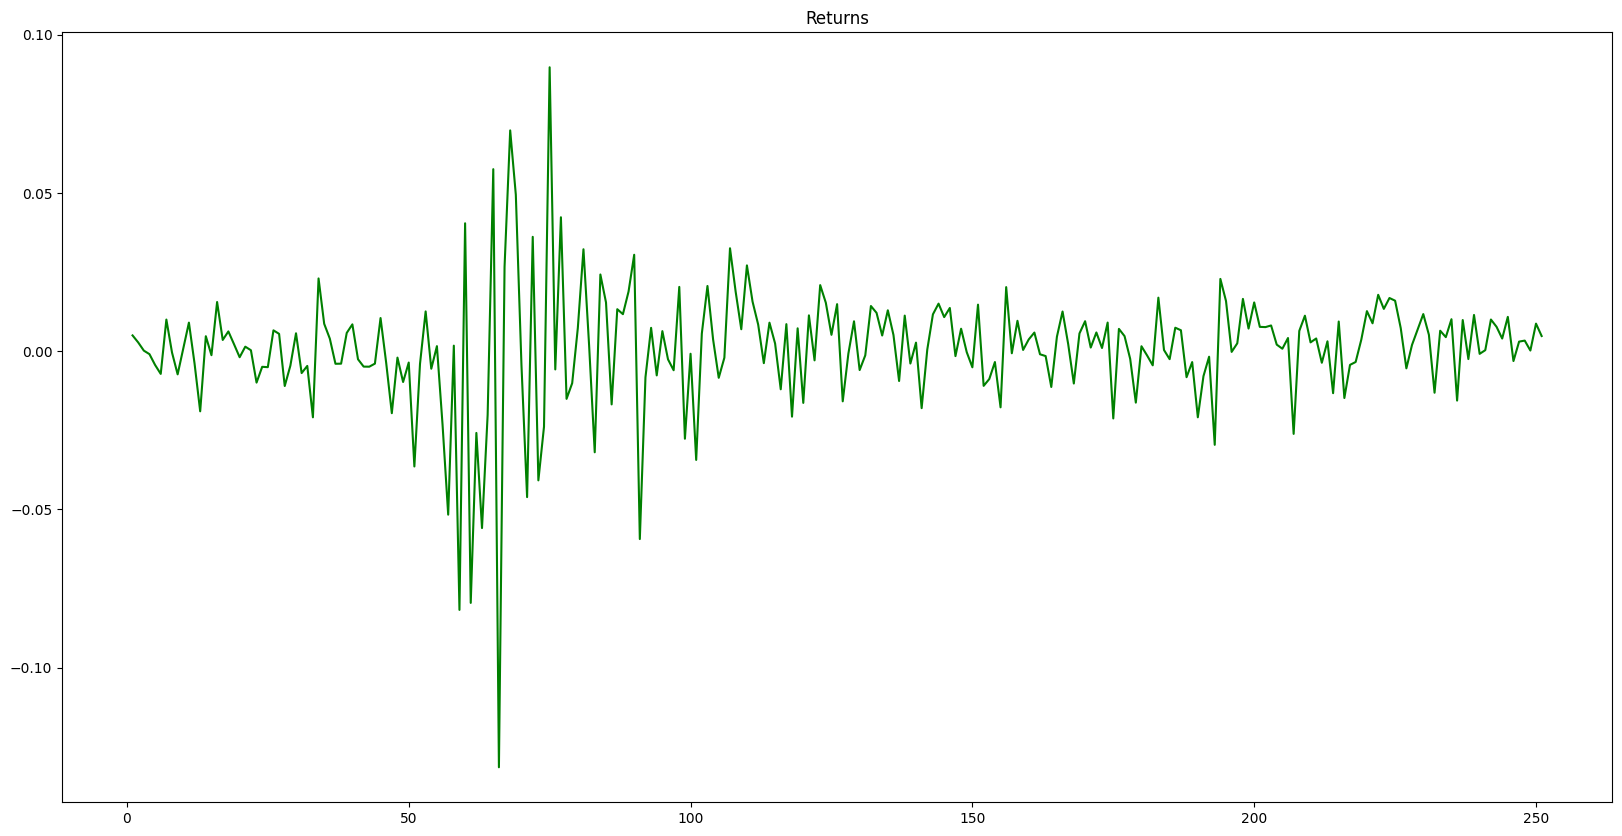

In [19]:
#Plotting returns
returns = close / close.shift(1) - 1

plt.figure(figsize = (20,10))
returns.plot(label='Return', color = 'g')
plt.title("Returns")

In [20]:
# Train test split
train = hisdf[:1219]
test = hisdf[1219:]

# Rolling mean and Standard Deviation

In [21]:
import numpy as np
from statsmodels.tsa.stattools import adfuller

# Example data (replace with your own data)
timeseries = np.array([1.0, 2.0, 3.0, 4.0, 5.0, np.nan, 7.0, 8.0, 9.0])

# Handle missing or infinite values in the time series data
timeseries = np.nan_to_num(timeseries, nan=0.0, posinf=1e10, neginf=-1e10)

# Perform the Augmented Dickey-Fuller (ADF) test
result = adfuller(timeseries, autolag='AIC')

# Extract ADF test results
adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]

# Print the results
print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')
print('Critical Values:')
for key, value in critical_values.items():
    print(f'   {key}: {value}')



ADF Statistic: -1.3206763594884356
p-value: 0.6196605721347497
Critical Values:
   1%: -4.6651863281249994
   5%: -3.3671868750000002
   10%: -2.802960625


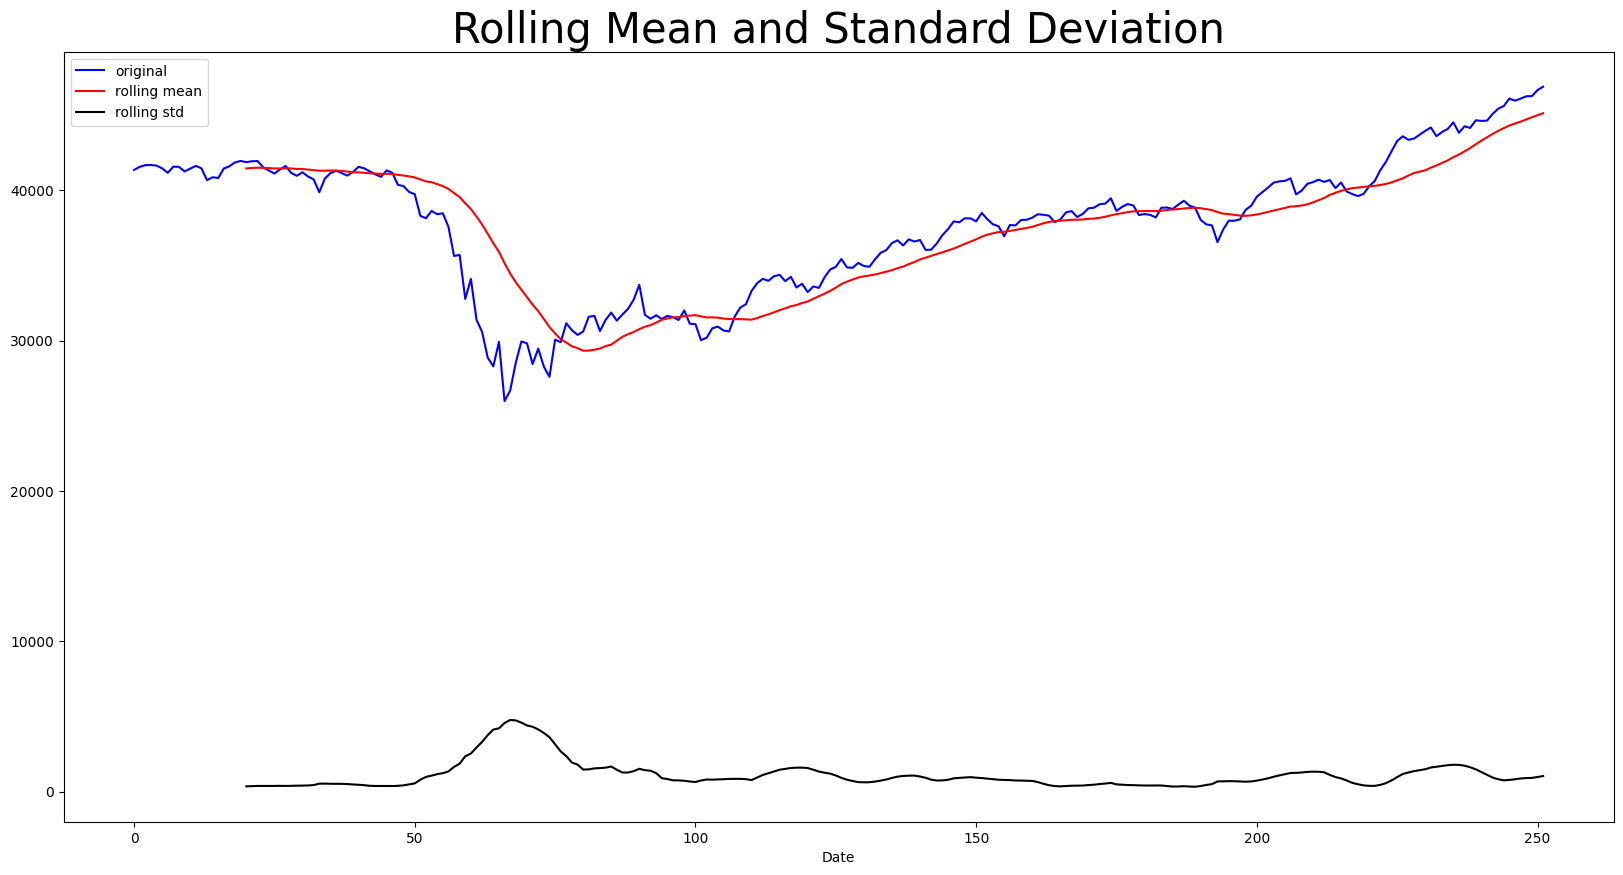

Results of dickey fuller test
0
0
ADF Test Statistic : -0.698285082749831
p-value : 0.8471932401708802
#Lags Used : 6
Number of Observations Used : 243
Weak evidence against null hypothesis, time series is non-stationary 


In [22]:
#Stationarity test
def test_stationarity(timeseries):

 #Determine the rolling statistics
 rolmean = timeseries.rolling(20).mean()
 rolstd = timeseries.rolling(20).std()

 #Plot rolling statistics:
 plt.figure(figsize = (20,10))
 plt.plot(timeseries, color = 'blue', label = 'original')
 plt.plot(rolmean, color = 'r', label = 'rolling mean')
 plt.plot(rolstd, color = 'black', label = 'rolling std')
 plt.xlabel('Date')
 plt.legend()
 plt.title('Rolling Mean and Standard Deviation',  fontsize = 30)
 plt.show(block = False)

 print('Results of dickey fuller test')
 print(timeseries.isna().sum())  # Check for NaN
 print(np.isinf(timeseries).sum())  # Check for inf

 result = adfuller(timeseries, autolag = 'AIC')
 labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
 for value,label in zip(result, labels):
   print(label+' : '+str(value) )
 if result[1] <= 0.05:
   print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
 else:
   print("Weak evidence against null hypothesis, time series is non-stationary ")
test_stationarity(train['Close'])

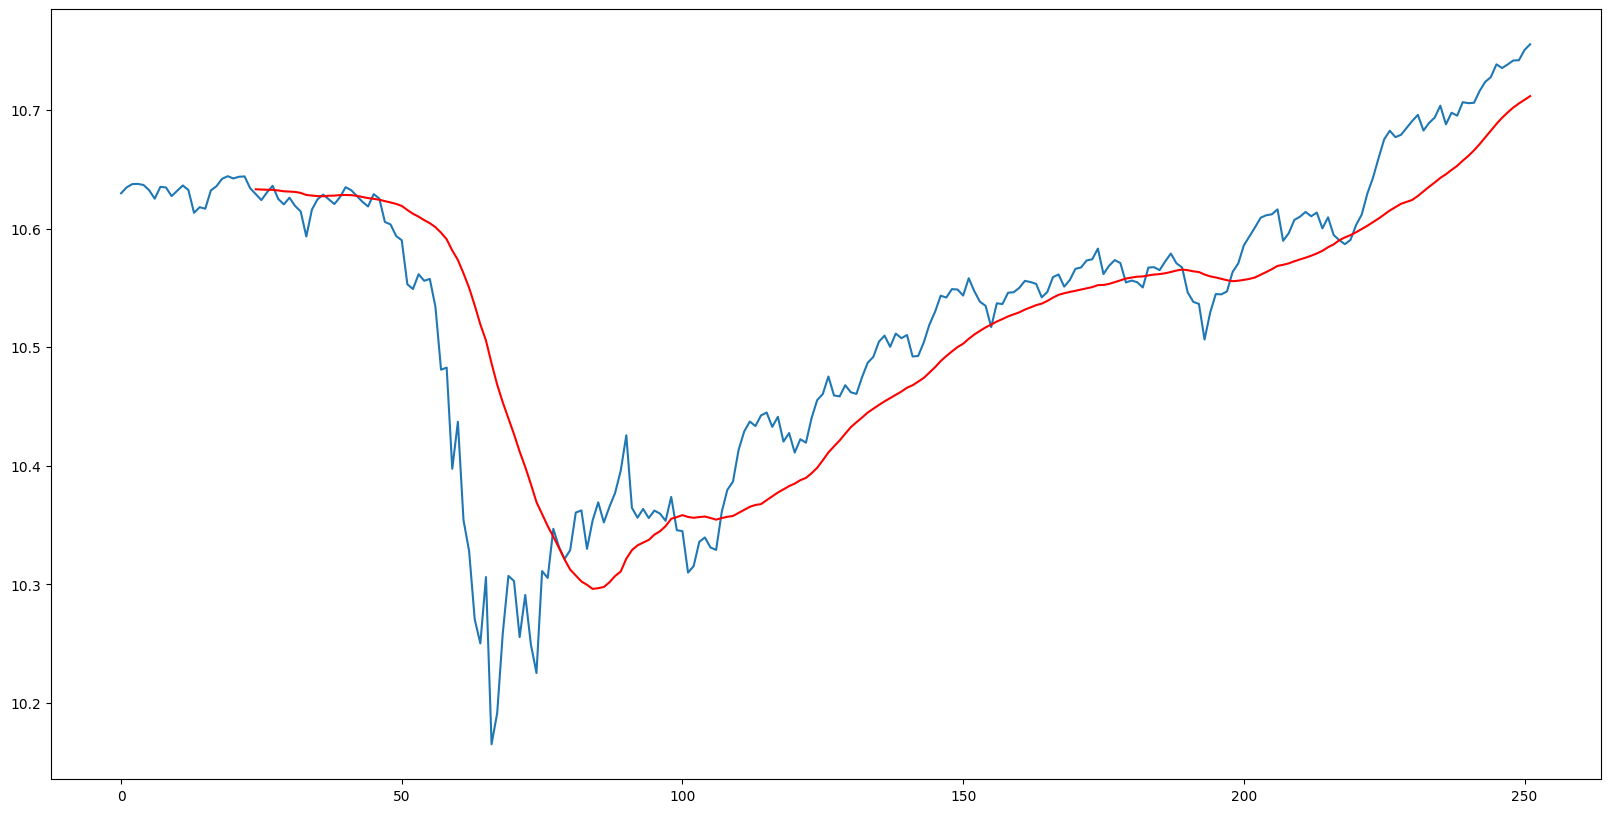

In [23]:
train_log = np.log(train['Close'])
test_log = np.log(test['Close'])

mav = train_log.rolling(24).mean()
plt.figure(figsize = (20,10))
plt.plot(train_log)
plt.plot(mav, color = 'red')

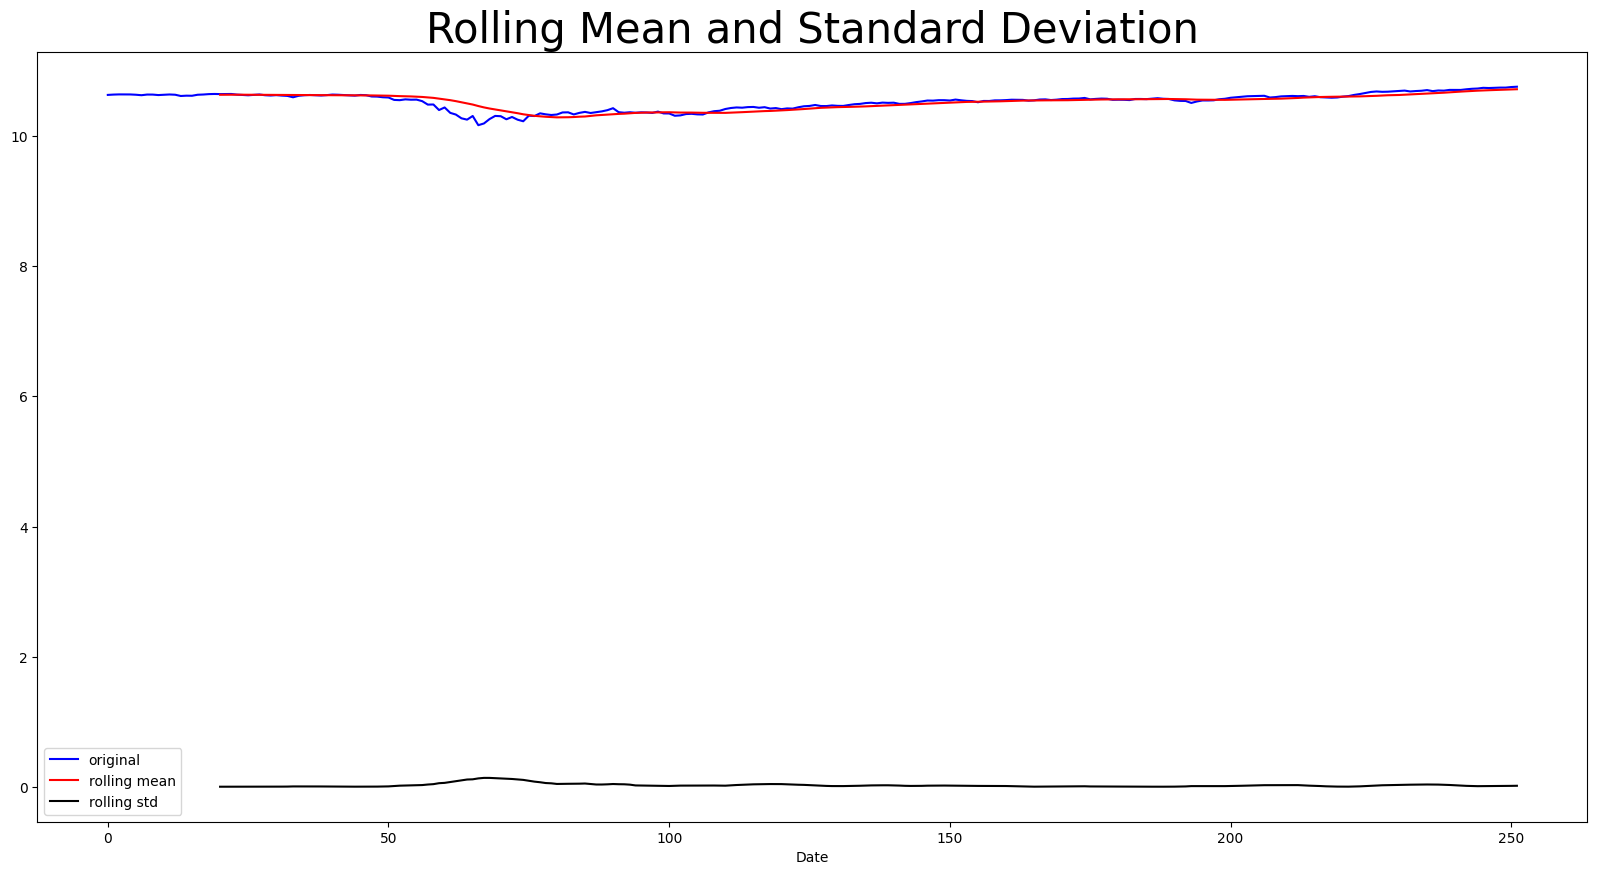

Results of dickey fuller test
0
0
ADF Test Statistic : -1.1857021490482853
p-value : 0.6797158478016483
#Lags Used : 7
Number of Observations Used : 242
Weak evidence against null hypothesis, time series is non-stationary 


In [24]:
train_log.dropna(inplace = True)
test_log.dropna(inplace = True)

test_stationarity(train_log)

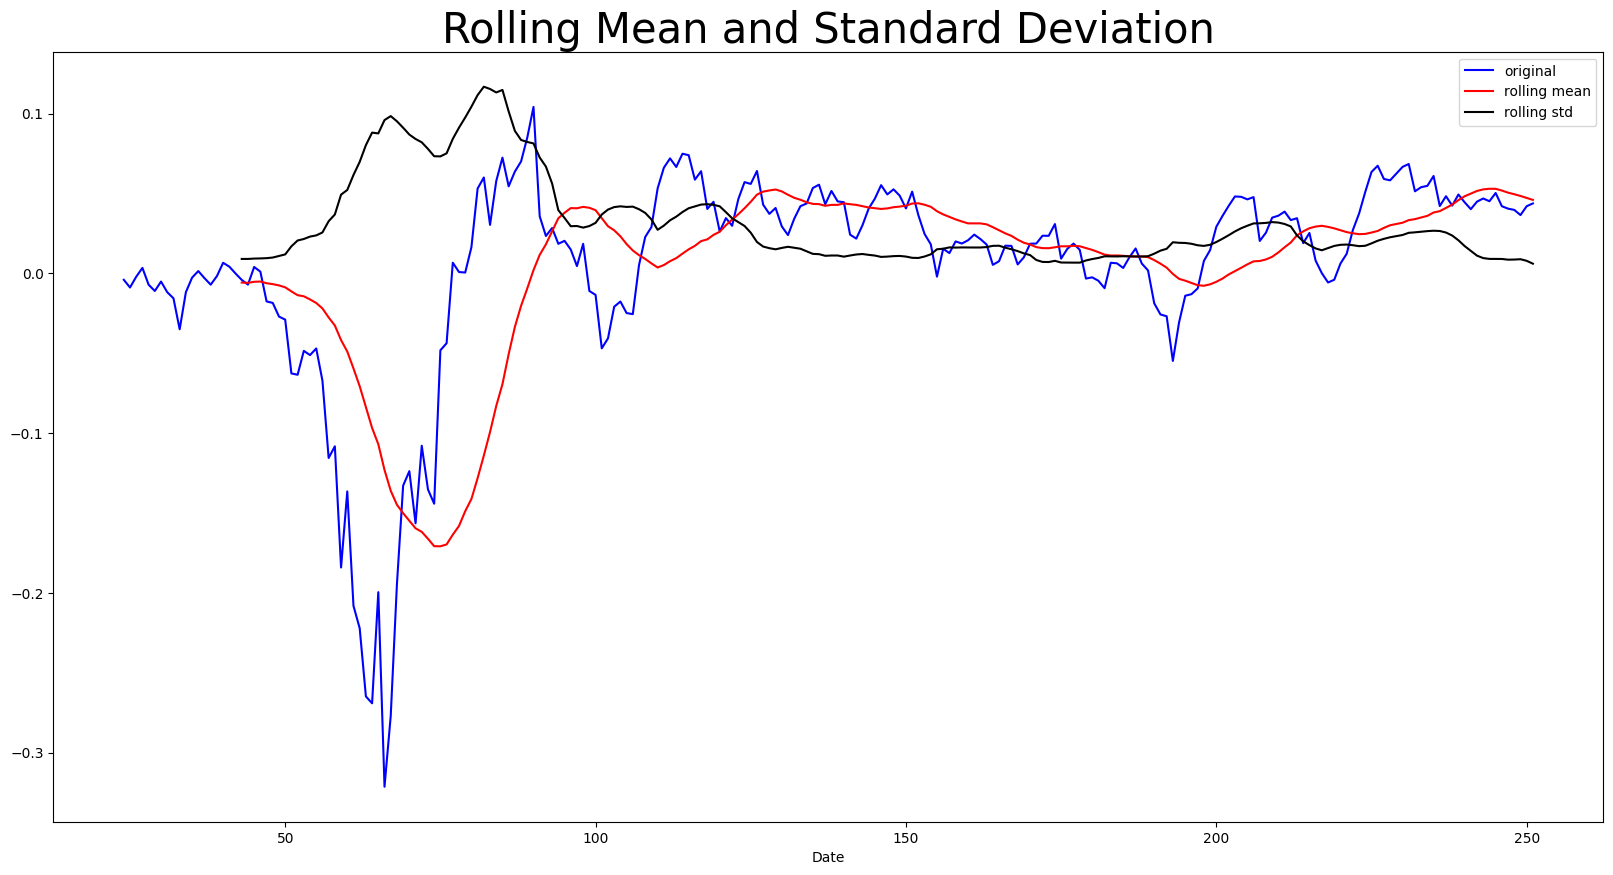

Results of dickey fuller test
0
0
ADF Test Statistic : -3.018810804327608
p-value : 0.03317466037433331
#Lags Used : 7
Number of Observations Used : 219
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


In [25]:
train_log_diff = train_log - mav
train_log_diff.dropna(inplace = True)

test_stationarity(train_log_diff)

In [26]:
pip install pmdarima

In [27]:
from pmdarima import auto_arima
model = auto_arima(train_log, trace = True, error_action = 'ignore', suppress_warnings = True)
model.fit(train_log)
predictions = model.predict(periods = len(test))
predictions = pd.DataFrame(predictions,index = test_log.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1229.181, Time=1.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1228.630, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1231.551, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1230.976, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1230.477, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1230.063, Time=0.33 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1229.768, Time=1.47 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1232.318, Time=0.84 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-1228.479, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1233.519, Time=0.66 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1230.635, Time=0.26 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-1233.464, Time=0.97 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-1231.040, Time=1.54 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-1233.160, Time=2.10 sec
 ARIMA(1,1,2)(0,0,0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Text(0, 0.5, 'Actual Stock Price')

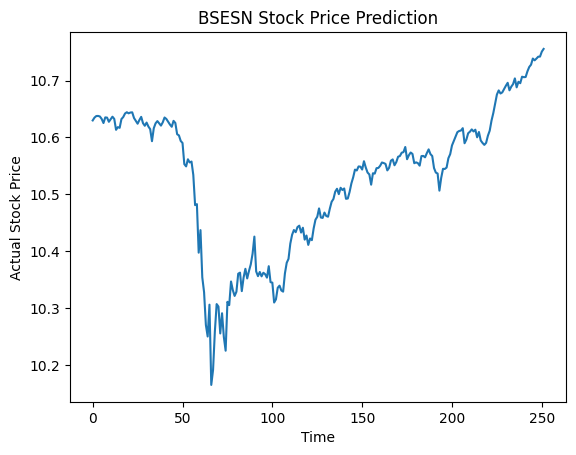

In [28]:
plt.plot(train_log, label='Train')
plt.plot(test_log, label='Test')
plt.plot(predictions, label='Prediction')
plt.title('BSESN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')

# Error Calculation

In [29]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming test_log and predictions are properly loaded and processed
# Example data:
test_log = np.array([2.5, 3.0, 4.0, 4.5, 5.0])
predictions = np.array([2.7, 3.2, 3.8, 4.3, 4.9])

# Calculate RMSE
rms = np.sqrt(mean_squared_error(test_log, predictions))
print("RMSE : ", rms)


RMSE :  0.18439088914585786


# Textual analysis

In [30]:
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
  return  TextBlob(text).sentiment.polarity

In [31]:
#Adding subjectivity and polarity columns
# Clean the 'News' column, replacing NaN with empty strings
news_data['News'] = news_data['News'].fillna('')

# Ensure the 'News' column is of string data type
news_data['News'] = news_data['News'].astype(str)

# Now, apply the getSubjectivity function
news_data['Subjectivity'] = news_data['News'].apply(getSubjectivity)

news_data['Polarity'] = news_data['News'].apply(getPolarity)
news_data

,Date,News,Subjectivity,Polarity
0,2001-01-02,Status quo will not be disturbed at Ayodhya s...,0.286859,0.143590
1,2001-01-03,Powerless north India gropes in the dark Think...,0.392857,0.089286
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,0.445360,0.093039
3,2001-01-05,Light combat craft takes India into club class...,0.480553,0.264024
4,2001-01-06,Light combat craft takes India into club class...,0.439394,0.248485
...,...,...,...,...
7712,2022-03-27,Playing a dead man in Body God meant sitting i...,0.365123,0.034162
7713,2022-03-28,As fashion becomes democratic demand for styl...,0.383007,0.058513
7714,2022-03-29,Bobby Deol Like my dad I hope to be working ...,0.403627,0.092144
7715,2022-03-30,I will not give in to trends Dossmode The tim...,0.344136,0.039954


In [32]:
#Adding sentiment score to df_news
import nltk
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [35]:
news_data['Negative'] = [sia.polarity_scores(v)['neg'] for v in news_data['News']]
news_data['Neutral'] = [sia.polarity_scores(v)['neu'] for v in news_data['News']]
news_data['Positive'] = [sia.polarity_scores(v)['pos'] for v in news_data['News']]
news_data


,Date,News,Subjectivity,Polarity,Negative,Neutral,Positive
0,2001-01-02,Status quo will not be disturbed at Ayodhya s...,0.286859,0.143590,0.121,0.809,0.071
1,2001-01-03,Powerless north India gropes in the dark Think...,0.392857,0.089286,0.156,0.735,0.109
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,0.445360,0.093039,0.104,0.792,0.104
3,2001-01-05,Light combat craft takes India into club class...,0.480553,0.264024,0.142,0.694,0.164
4,2001-01-06,Light combat craft takes India into club class...,0.439394,0.248485,0.214,0.655,0.131
...,...,...,...,...,...,...,...
7712,2022-03-27,Playing a dead man in Body God meant sitting i...,0.365123,0.034162,0.158,0.758,0.084
7713,2022-03-28,As fashion becomes democratic demand for styl...,0.383007,0.058513,0.160,0.737,0.103
7714,2022-03-29,Bobby Deol Like my dad I hope to be working ...,0.403627,0.092144,0.159,0.755,0.086
7715,2022-03-30,I will not give in to trends Dossmode The tim...,0.344136,0.039954,0.156,0.769,0.076


# Merge the Historical and Textual Data

In [36]:
df_merge = pd.merge(hisdf, news_data, how='outer', on='Date')
df_merge

,Date,Open,High,Low,Close,Volume,News,Subjectivity,Polarity,Negative,Neutral,Positive
0,2019-12-17,41052.359375,41401.648438,41005.179688,41352.171875,19000.0,After Jagannath Temple Puri beach devpt plan ...,0.356256,0.037977,0.206,0.715,0.079
1,2019-12-18,41442.750000,41614.769531,41358.468750,41558.570313,24300.0,What is Citizenship Amendment Bill All...,0.396291,0.039680,0.164,0.754,0.082
2,2019-12-19,41571.820313,41719.289063,41456.398438,41673.921875,33300.0,Only of CCA covered after revamp of canals...,0.371783,0.029115,0.135,0.797,0.068
3,2019-12-20,41746.199219,41809.960938,41636.109375,41681.539063,33600.0,I'm done playing the good girl I want to be a...,0.366210,0.047456,0.179,0.733,0.088
4,2019-12-23,41548.261719,41701.621094,41474.609375,41642.660156,6200.0,Weekly Horoscope December Check predic...,0.393635,0.036077,0.157,0.753,0.091
...,...,...,...,...,...,...,...,...,...,...,...,...
7712,2022-03-27,NaN,NaN,NaN,NaN,NaN,Playing a dead man in Body God meant sitting i...,0.365123,0.034162,0.158,0.758,0.084
7713,2022-03-28,NaN,NaN,NaN,NaN,NaN,As fashion becomes democratic demand for styl...,0.383007,0.058513,0.160,0.737,0.103
7714,2022-03-29,NaN,NaN,NaN,NaN,NaN,Bobby Deol Like my dad I hope to be working ...,0.403627,0.092144,0.159,0.755,0.086
7715,2022-03-30,NaN,NaN,NaN,NaN,NaN,I will not give in to trends Dossmode The tim...,0.344136,0.039954,0.156,0.769,0.076


In [37]:
df_merge = df_merge.dropna(how='any')
df_merge

,Date,Open,High,Low,Close,Volume,News,Subjectivity,Polarity,Negative,Neutral,Positive
0,2019-12-17,41052.359375,41401.648438,41005.179688,41352.171875,19000.0,After Jagannath Temple Puri beach devpt plan ...,0.356256,0.037977,0.206,0.715,0.079
1,2019-12-18,41442.750000,41614.769531,41358.468750,41558.570313,24300.0,What is Citizenship Amendment Bill All...,0.396291,0.039680,0.164,0.754,0.082
2,2019-12-19,41571.820313,41719.289063,41456.398438,41673.921875,33300.0,Only of CCA covered after revamp of canals...,0.371783,0.029115,0.135,0.797,0.068
3,2019-12-20,41746.199219,41809.960938,41636.109375,41681.539063,33600.0,I'm done playing the good girl I want to be a...,0.366210,0.047456,0.179,0.733,0.088
4,2019-12-23,41548.261719,41701.621094,41474.609375,41642.660156,6200.0,Weekly Horoscope December Check predic...,0.393635,0.036077,0.157,0.753,0.091
...,...,...,...,...,...,...,...,...,...,...,...,...
245,2020-12-11,46060.320313,46309.628906,45706.218750,46099.011719,26300.0,Ways to get you in the mood for sex when you'r...,0.374037,0.052291,0.168,0.743,0.089
246,2020-12-14,46284.699219,46373.339844,45951.531250,46253.460938,18400.0,No threat from Covid claims to balance sheets ...,0.382335,0.072333,0.128,0.776,0.095
247,2020-12-15,46287.390625,46350.300781,45841.671875,46263.171875,16400.0,RT PCR tests in a day only found ve ...,0.368751,0.039336,0.145,0.767,0.089
248,2020-12-16,46573.308594,46704.968750,46402.199219,46666.460938,13100.0,Asmita Sood's favourite holiday destinations a...,0.427681,0.067088,0.124,0.793,0.083


In [38]:
dfmerge1 = df_merge[['Close','Subjectivity', 'Polarity', 'Negative', 'Neutral', 'Positive']]
dfmerge1

,Close,Subjectivity,Polarity,Negative,Neutral,Positive
0,41352.171875,0.356256,0.037977,0.206,0.715,0.079
1,41558.570313,0.396291,0.039680,0.164,0.754,0.082
2,41673.921875,0.371783,0.029115,0.135,0.797,0.068
3,41681.539063,0.366210,0.047456,0.179,0.733,0.088
4,41642.660156,0.393635,0.036077,0.157,0.753,0.091
...,...,...,...,...,...,...
245,46099.011719,0.374037,0.052291,0.168,0.743,0.089
246,46253.460938,0.382335,0.072333,0.128,0.776,0.095
247,46263.171875,0.368751,0.039336,0.145,0.767,0.089
248,46666.460938,0.427681,0.067088,0.124,0.793,0.083


# Normalizing Data

In [39]:

scaler = MinMaxScaler()

df = pd.DataFrame(scaler.fit_transform(dfmerge1))
df.columns = dfmerge1.columns
df.index = dfmerge1.index
df.head()

,Close,Subjectivity,Polarity,Negative,Neutral,Positive
0,0.735131,0.157604,0.254831,0.913386,0.044118,0.296296
1,0.745002,0.537627,0.270044,0.582677,0.330882,0.333333
2,0.750519,0.304990,0.175669,0.354331,0.647059,0.160494
3,0.750884,0.252084,0.339500,0.700787,0.176471,0.407407
4,0.749024,0.512408,0.237860,0.527559,0.323529,0.444444


In [40]:
X=df.drop('Close',axis=1)
X

,Subjectivity,Polarity,Negative,Neutral,Positive
0,0.157604,0.254831,0.913386,0.044118,0.296296
1,0.537627,0.270044,0.582677,0.330882,0.333333
2,0.304990,0.175669,0.354331,0.647059,0.160494
3,0.252084,0.339500,0.700787,0.176471,0.407407
4,0.512408,0.237860,0.527559,0.323529,0.444444
...,...,...,...,...,...
245,0.326385,0.382691,0.614173,0.250000,0.419753
246,0.405146,0.561721,0.299213,0.492647,0.493827
247,0.276208,0.266972,0.433071,0.426471,0.419753
248,0.835584,0.514876,0.267717,0.617647,0.345679


In [41]:
Y=df['Close']
Y

0      0.735131
1      0.745002
2      0.750519
3      0.750884
4      0.749024
         ...   
245    0.962154
246    0.969541
247    0.970005
248    0.989293
249    1.000000
Name: Close, Length: 250, dtype: float64

# Split the Dataset into Train & Test Data

In [42]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 0)
x_train.shape

(200, 5)

In [43]:
x_train[:10]

,Subjectivity,Polarity,Negative,Neutral,Positive
71,0.352071,0.288092,0.401575,0.500000,0.333333
160,0.681128,0.572245,0.417323,0.500000,0.308642
180,0.686480,0.370186,0.535433,0.250000,0.543210
75,0.502568,0.748241,0.322835,0.588235,0.308642
59,0.367044,0.196113,0.850394,0.073529,0.345679
101,0.600065,0.456315,0.322835,0.595588,0.296296
229,0.592298,0.326265,0.559055,0.433824,0.197531
18,0.673951,0.602135,0.692913,0.227941,0.333333
188,0.671094,0.314921,0.251969,0.838235,0.000000
15,0.307918,0.606835,0.496063,0.367647,0.407407


# RandomForestRegressor Model

In [44]:
rf = RandomForestRegressor()
rf.fit(x_train, y_train)
prediction=rf.predict(x_test)
print(prediction[:10])
print(y_test[:10])
print('Mean Squared error: ',mean_squared_error(prediction,y_test))

[0.54682536 0.40849848 0.54806    0.63311536 0.51343304 0.36395683
 0.52036275 0.6431941  0.41111278 0.51014771]
225    0.842333
122    0.393456
92     0.272824
157    0.576027
154    0.524095
161    0.592488
198    0.621378
83     0.258180
63     0.110334
155    0.559884
Name: Close, dtype: float64
Mean Squared error:  0.0328567569228692


# DecisionTreeRegressor Model

In [45]:
dtr = DecisionTreeRegressor()
dtr.fit(x_train, y_train)
predictions = dtr.predict(x_test)
print(predictions[:10])
print(y_test[:10])
print('Mean Squared error: ',mean_squared_error(predictions,y_test))

[0.48163568 0.86892687 0.61567981 0.62167246 0.60485861 0.74535291
 0.58097472 0.74825797 0.25868307 0.50246262]
225    0.842333
122    0.393456
92     0.272824
157    0.576027
154    0.524095
161    0.592488
198    0.621378
83     0.258180
63     0.110334
155    0.559884
Name: Close, dtype: float64
Mean Squared error:  0.06990187417642017


# XGBRegressor Model

In [46]:
xgb = xgboost.XGBRegressor()
xgb.fit(x_train, y_train)
predictions = xgb.predict(x_test)
print(mean_squared_error(predictions, y_test))

0.04662202407119738


# AdaBoostRegressor Model

In [47]:
adb = AdaBoostRegressor()
adb.fit(x_train, y_train)
predictions = adb.predict(x_test)
print(mean_squared_error(predictions, y_test))

0.03563032361072491


# CONCLUSION

RANDOM FOREST - 0.0328567569228692,

DECISION TREE - 0.06990187417642017,

XGBREGRESSION MODEL - 0.04662202407119738,

ADABOOST REGESSION MODEL - 0.03563032361072491,

FROM THESE WE CAN CLEARLY SEE RANDOM FOREST PERFORM BETTER THAN THE OTHERS.